In [ ]:
!pip install -q transformers datasets tokenizers

# Домашнее задание. Transformers.

Привет! Это очередное домашнее задание, но теперь ты познакомишься с моделя трансформеров и с библиотекой `HuggingFace🤗`. В этом задании будет предложено решить с помощью модели `GPT2` простую задачу (анализ сентимента) и сделать небольшое исследование карт внимания. Приступим!

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import ticker

import torch
import torch.nn as nn
import torch.optim as optim

from transformers import GPT2ForSequenceClassification, GPT2TokenizerFast, GPT2Config
from datasets import load_dataset

In [2]:
device = "cuda" if torch.cuda.is_available else "cpu"

Датасет, который мы будем использовать сегодня – тексты из английского твиттера. Они уже почищенны от никнеймов, знаков препинания и прочего. 

In [3]:
emotion_dataset = load_dataset("emotion")

Using custom data configuration default
Reusing dataset emotion (C:\Users\BIT\.cache\huggingface\datasets\emotion\default\0.0.0\348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705)


  0%|          | 0/3 [00:00<?, ?it/s]

Посмотри, из чего состоит `emotion_dataset`:

In [4]:
emotion_dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

In [5]:
emotion_dataset["train"]

Dataset({
    features: ['text', 'label'],
    num_rows: 16000
})

In [6]:
emotion_dataset["train"]["text"][0]

'i didnt feel humiliated'

In [7]:
emotion_dataset["train"]["label"][0]

0

In [8]:
len(emotion_dataset["train"])

16000

Для перевода текста в токены мы будем использовать предобученный BPE-токенайзер.

In [9]:
tokenizer = GPT2TokenizerFast.from_pretrained("distilgpt2")
tokenizer.pad_token = tokenizer.eos_token # У gpt2 нет pad токенов. Вместо них воспользуемся токенами конца текста.

Подготовь класс, который принимает датасет, токенайзер и имя используемой части (`train`, `validation`, `test`). Используй его для получения данных для обучения.

P.S. Посмотри, как работает токенайзер ([docs](https://huggingface.co/transformers/main_classes/tokenizer.html)) и подумай, как его надо добавить в датасет.

Немного примеров, как работает токенайзер. Это поможет с написанием датасета.

In [10]:
tokenizer.tokenize(emotion_dataset["train"]["text"][0])

['i', 'Ġdidnt', 'Ġfeel', 'Ġhumiliated']

In [11]:
tokenizer.encode(emotion_dataset["train"]["text"][0])

[72, 42547, 1254, 42659]

In [12]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0])

{'input_ids': [72, 42547, 1254, 42659], 'attention_mask': [1, 1, 1, 1]}

In [13]:
tokenizer.encode_plus(emotion_dataset["train"]["text"][0], return_tensors="pt")

{'input_ids': tensor([[   72, 42547,  1254, 42659]]), 'attention_mask': tensor([[1, 1, 1, 1]])}

In [14]:
tokenizer.encode_plus(
    emotion_dataset["train"]["text"][0], 
    max_length=128, # максимальная длина текста
    padding="max_length", # надо ли добавлять паддинг в конце?
    return_tensors="pt", # возвращает pytorch тензоры
)

{'input_ids': tensor([[   72, 42547,  1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256,
         50256, 50256, 50256, 50256, 5

In [15]:
tokenizer(emotion_dataset["train"]["text"][0],max_length=128,padding="max_length")

{'input_ids': [72, 42547, 1254, 42659, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256, 50256], 'attention_mask': [1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0

In [16]:
class TweetDataset(torch.utils.data.Dataset):
    def __init__(self, part, dataset=emotion_dataset, tokenizer=tokenizer, max_length=128):
        self.part = part
        self.dataset = dataset
        self.tokenizer = tokenizer
        self.max_length = max_length
        
        self.labels = np.unique(dataset[part]["label"])
        self.label2num = {l: num for num, l in enumerate(self.labels)}
        
    def __getitem__(self, idx):
        """
        Return dict with tokens, attention_mask and label
        """
        text = self.dataset[self.part]['text'][idx]
        label = self.dataset[self.part]['label'][idx]
        
        tokenizer_output = self.tokenizer(text,return_tensors="pt",max_length=128,padding="max_length")
        target = self.label2num[label]
        return {
            "input_ids": tokenizer_output["input_ids"], 
            "mask": tokenizer_output["attention_mask"],
            "target": target
        }
        
    def __len__(self):
        """
        Return length of dataset
        """
        return len(self.dataset[self.part])

Создай `train`, `validation` и `test` части датасета. Загрузи их в `DataLoaders`.

In [17]:
train_dataset = TweetDataset('train')
valid_dataset = TweetDataset('validation') # validation
test_dataset = TweetDataset('test')

In [18]:
batch_size = 56 # Задай batch_size

train_loader = torch.utils.data.DataLoader(
    train_dataset,batch_size
)
valid_loader = torch.utils.data.DataLoader(
    valid_dataset,batch_size
)
test_loader = torch.utils.data.DataLoader(
    test_dataset,batch_size
)

## Начнем с нуля.

Попробуем обучить модель трансформер с нуля решать данную задачу.

In [20]:
config = GPT2Config.from_pretrained(
    "distilgpt2", # distilgpt2 – уменьшенная версия модели gpt2
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
)
model_0 = GPT2ForSequenceClassification(config=config).to(device) # GPT2 для классификации текста

Подготовь оптимайзер и критерий:

In [21]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = optim.Adam(model_0.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Посмотри, что возвращает модель ([docs](https://huggingface.co/transformers/model_doc/gpt2.html#gpt2forsequenceclassification)), если в неё подать данные:

In [22]:
tokens = train_dataset[0]["input_ids"] # Получи токены из датасета
mask = train_dataset[0]["mask"] # Получи маску из датасета

model_0(tokens.to(device),attention_mask=mask.to(device)) # Посмотри на аутпут

SequenceClassifierOutputWithPast(loss=None, logits=tensor([[-0.6016,  0.3945, -0.0352,  0.2383, -0.2833, -0.3858, -0.4415,  0.2144]],
       device='cuda:0', grad_fn=<IndexBackward>), past_key_values=((tensor([[[[ 0.0693, -0.4933,  0.6084,  ..., -0.1099, -0.2499,  0.1885],
          [ 0.0530, -0.2895,  0.7791,  ..., -0.1166, -0.7112,  0.8846],
          [ 0.1279, -0.5819, -0.7769,  ...,  0.8948,  0.3124,  0.0403],
          ...,
          [ 0.4345,  0.5728,  0.1438,  ...,  0.5038, -0.5029, -0.0324],
          [ 0.5741,  0.3700,  0.1286,  ..., -0.3909,  0.2086, -0.1740],
          [ 0.9738,  0.5600,  0.3009,  ...,  0.5526, -0.2051, -0.3787]],

         [[-0.2065, -0.3327,  0.0147,  ...,  0.2201,  0.1665, -0.4037],
          [ 0.7941,  0.2119,  0.9424,  ..., -0.1566,  0.6468, -1.3651],
          [ 0.3720,  0.6090,  0.3804,  ...,  0.8036,  1.8777,  0.3231],
          ...,
          [ 0.2045,  0.0446, -0.6182,  ..., -0.5854,  0.4760, -0.5089],
          [-0.0219, -0.6031, -0.7517,  ..., -0

Обучи модель с помощью `train_dataset`, проверяй во время обучения качество с помощью `valid_dataset` и получи финальное качество с помощью `test_dataset`.

In [23]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_0.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        tokens_batch=batch['input_ids'].squeeze(1).to(device)
        labels_batch=batch['target'].to(device)
        mask_batch=batch['mask'].squeeze(1).to(device)
        logits=model_0(tokens_batch,attention_mask=mask_batch)['logits']
        loss=criterion(logits,labels_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    valid_loss = 0
    valid_acc = 0
    model_0.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens_batch=batch['input_ids'].squeeze(1).to(device)
            labels_batch=batch['target'].to(device)
            mask_batch=batch['mask'].squeeze(1).to(device)
            logits=model_0(tokens_batch,attention_mask=mask_batch)['logits']
            loss=criterion(logits,labels_batch)
            valid_loss+=loss.item()
            preds=torch.softmax(logits,dim=1).argmax(1)
            valid_acc+=sum(preds==labels_batch)
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_0.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens_batch=batch['input_ids'].squeeze(1).to(device)
        labels_batch=batch['target'].to(device)
        mask_batch=batch['mask'].squeeze(1).to(device)
        logits=model_0(tokens_batch,attention_mask=mask_batch)['logits']
        preds=torch.softmax(logits,dim=1).argmax(1)
        test_acc+=sum(preds==labels_batch)
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 1.5695417581738291,Valid Loss: 1.4308452639314864,Valid Acc: 25.63888931274414


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 1.2416164945889185,Valid Loss: 1.0044941554466884,Valid Acc: 34.83333206176758


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.8222977279366314,Valid Loss: 0.6984481132692761,Valid Acc: 41.58333206176758


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.5475620444525372,Valid Loss: 0.5499217154251205,Valid Acc: 45.25


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.34415814574886033,Valid Loss: 0.45321451624234516,Valid Acc: 47.75


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.23395119077311113,Valid Loss: 0.39348654655946624,Valid Acc: 49.11111068725586


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.18255321742068012,Valid Loss: 0.3676004180063804,Valid Acc: 49.30555725097656


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.13400590070034865,Valid Loss: 0.3699541750053565,Valid Acc: 49.52777862548828


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.1074842282609975,Valid Loss: 0.3648984022438526,Valid Acc: 49.83333206176758


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.0923691242737891,Valid Loss: 0.3498164005577564,Valid Acc: 49.88888931274414
Test Acc: 49.33333206176758


In [24]:
#torch.save(model_0.state_dict(),'model_0')
#model_0.load_state_dict(torch.load('model_0'))

После того, как получил лучшую модель для решения этой задачи, посмотри на карты внимания. Нашел ли что-нибудь интересное в них?

In [25]:
def get_attention_matrixes(model, tokenizer, text, device=device):
    inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
    inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
    attn_tensors = model(inp)[-1]
    seq = [tokenizer.decode(x) for x in inp[0].tolist()]
    attn = []
    for i in range(len(attn_tensors)):
        attn_layer = []
        for j in range(attn_tensors[i].size(1)):
            attn_layer.append(attn_tensors[i][0, j].cpu().detach().numpy())
        attn.append(np.array(attn_layer))
    
    return np.array(attn)

In [26]:
def show_attention(seq, attentions):
    # Set up figure with colorbar
    fig = plt.figure(figsize=(20,20))
    ax = fig.add_subplot(111)
    cax = ax.matshow(attentions)
    fig.colorbar(cax)

    # Set up axes
    ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
    ax.set_yticklabels(['']+seq, fontsize=16)

    # Show label at every tick
    ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

    plt.show()

In [27]:
text = emotion_dataset['train']['text'][10] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

C:\Users\BIT\AppData\Local\Temp/ipykernel_20796/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
C:\Users\BIT\AppData\Local\Temp/ipykernel_20796/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


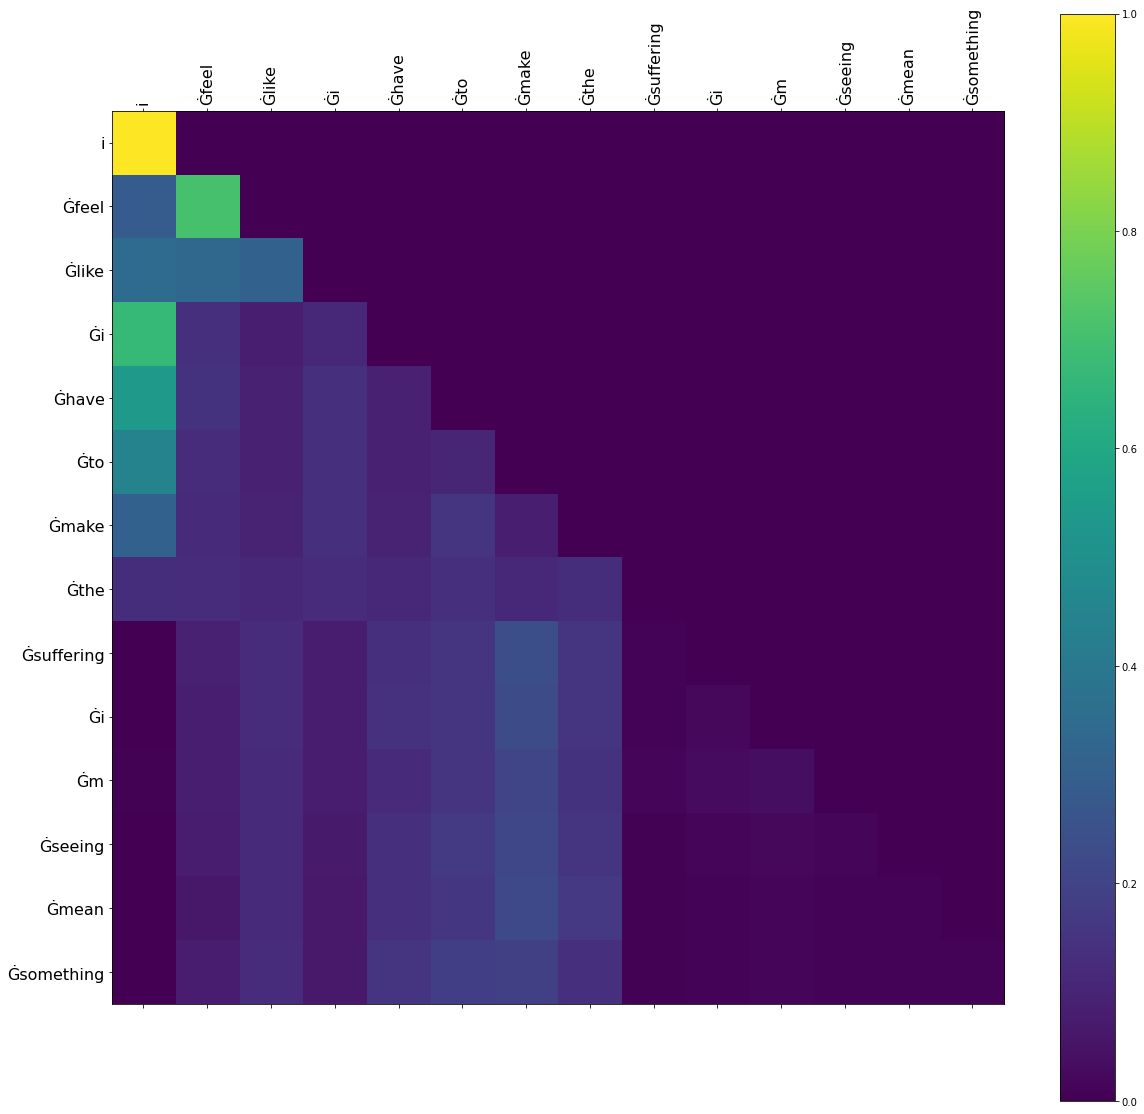

In [28]:
attns = get_attention_matrixes(model_0, tokenizer, text)
show_attention(tokens, attns[-1][0])

In [29]:
from bertviz import model_view

In [30]:
def call_html():
    import IPython
    IPython.display.display(IPython.core.display.HTML('''
        <script src="/static/components/requirejs/require.js"></script>
        <script>
          requirejs.config({
            paths: {
              base: '/static/base',
              "d3": "https://cdnjs.cloudflare.com/ajax/libs/d3/5.7.0/d3.min",
              jquery: '//ajax.googleapis.com/ajax/libs/jquery/2.0.0/jquery.min',
            },
          });
        </script>
        '''))

In [31]:
text = emotion_dataset['train']['text'][10]
inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
input_ids = tokenizer(text,return_tensors="pt",max_length=len(text))['input_ids']
attention = model_0(inp)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<IPython.core.display.Javascript object>

## Fine-tuning

Теперь другой подход: загрузим модель, которая обучалась решать задачу Language Modeling. Посмотрим, получим ли мы прирост в качестве.

In [32]:
#import gc
#gc.collect()
#torch.cuda.empty_cache()
#torch.cuda.reset_max_memory_allocated()
#torch.cuda.synchronize()

C:\Users\BIT\.conda\envs\deep\lib\site-packages\torch\cuda\memory.py:231: FutureWarning: torch.cuda.reset_max_memory_allocated now calls torch.cuda.reset_peak_memory_stats, which resets /all/ peak memory stats.
  warnings.warn(


In [19]:
model_1 = GPT2ForSequenceClassification.from_pretrained(
    "distilgpt2", 
    output_attentions=True,
    pad_token_id=tokenizer.eos_token_id,
    num_labels=8
).to(device)

Some weights of the model checkpoint at distilgpt2 were not used when initializing GPT2ForSequenceClassification: ['lm_head.weight']
- This IS expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GPT2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at distilgpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [20]:
lr = 1e-5 # Предполагаемый learning rate. Он может быть больше или меньше :)

optimizer = optim.Adam(model_1.parameters(),lr=lr)
criterion = nn.CrossEntropyLoss()
# scheduler = ... # Можно добавить шедулер для обучения моделей. Это на твое усмотрение

Вывод модели ничем не отличается от предыдущего случая, поэтому сразу приступаем к обучению:

In [21]:
from tqdm.notebook import tqdm


num_epochs = 10

# Train loop
for e in range(num_epochs):
    model_1.train()
    train_loss = 0
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        tokens_batch=batch['input_ids'].squeeze(1).to(device)
        labels_batch=batch['target'].to(device)
        mask_batch=batch['mask'].squeeze(1).to(device)
        logits=model_1(tokens_batch,attention_mask=mask_batch)['logits']
        loss=criterion(logits,labels_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    valid_loss = 0
    valid_acc = 0
    model_1.eval()
    with torch.no_grad():
        for batch in valid_loader:
            tokens_batch=batch['input_ids'].squeeze(1).to(device)
            labels_batch=batch['target'].to(device)
            mask_batch=batch['mask'].squeeze(1).to(device)
            logits=model_1(tokens_batch,attention_mask=mask_batch)['logits']
            loss=criterion(logits,labels_batch)
            valid_loss+=loss.item()
            preds=torch.softmax(logits,dim=1).argmax(1)
            valid_acc+=sum(preds==labels_batch)
    print(f"Train Loss: {train_loss / len(train_loader)},"
          f"Valid Loss: {valid_loss / len(valid_loader)},"
          f"Valid Acc: {valid_acc / len(valid_loader)}")
        
# Testing
test_acc = 0
model_1.eval()
with torch.no_grad():
    for batch in test_loader:
        tokens_batch=batch['input_ids'].squeeze(1).to(device)
        labels_batch=batch['target'].to(device)
        mask_batch=batch['mask'].squeeze(1).to(device)
        logits=model_1(tokens_batch,attention_mask=mask_batch)['logits']
        preds=torch.softmax(logits,dim=1).argmax(1)
        test_acc+=sum(preds==labels_batch)
print(f"Test Acc: {test_acc / len(test_loader)}")

  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 1.5112682370455948,Valid Loss: 0.8345758219559988,Valid Acc: 39.86111068725586


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.5773477258903164,Valid Loss: 0.3282316153248151,Valid Acc: 49.55555725097656


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.31078552723035113,Valid Loss: 0.2397037266443173,Valid Acc: 51.08333206176758


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.22969150063874838,Valid Loss: 0.19116798198471466,Valid Acc: 51.4444465637207


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.18623501945521448,Valid Loss: 0.16945430957194832,Valid Acc: 51.80555725097656


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.1599372486238713,Valid Loss: 0.1677772223742472,Valid Acc: 51.4444465637207


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.14211291434907622,Valid Loss: 0.157393635250628,Valid Acc: 51.77777862548828


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.13298230648197076,Valid Loss: 0.16087092510941955,Valid Acc: 51.72222137451172


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.12415906416994708,Valid Loss: 0.14627024417536127,Valid Acc: 51.88888931274414


  0%|          | 0/286 [00:00<?, ?it/s]

Train Loss: 0.11300669578262247,Valid Loss: 0.1456554855944382,Valid Acc: 51.86111068725586
Test Acc: 51.47222137451172


In [22]:
#torch.save(model_1.state_dict(),'model_1')
#model_1.load_state_dict(torch.load('model_1'))

Есть ли прирост качества или скорости обучения?

> Ответ: небольшой прирост качества есть, по скорости обучения практически идентичны

Посмотри на карты внимания. Есть ли отличие от предыдущего случая?

> Ответ: предыдущая модель сохраняет внимательность по всему предложения, а данная модель в основном наиболее внимательна только к первому слову 

In [27]:
text = emotion_dataset['train']['text'][10] # Выбери текст из датасета
tokens = tokenizer.tokenize(text)

C:\Users\BIT\AppData\Local\Temp/ipykernel_23196/1202738048.py:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+seq, rotation=90, fontsize=16)
C:\Users\BIT\AppData\Local\Temp/ipykernel_23196/1202738048.py:10: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+seq, fontsize=16)


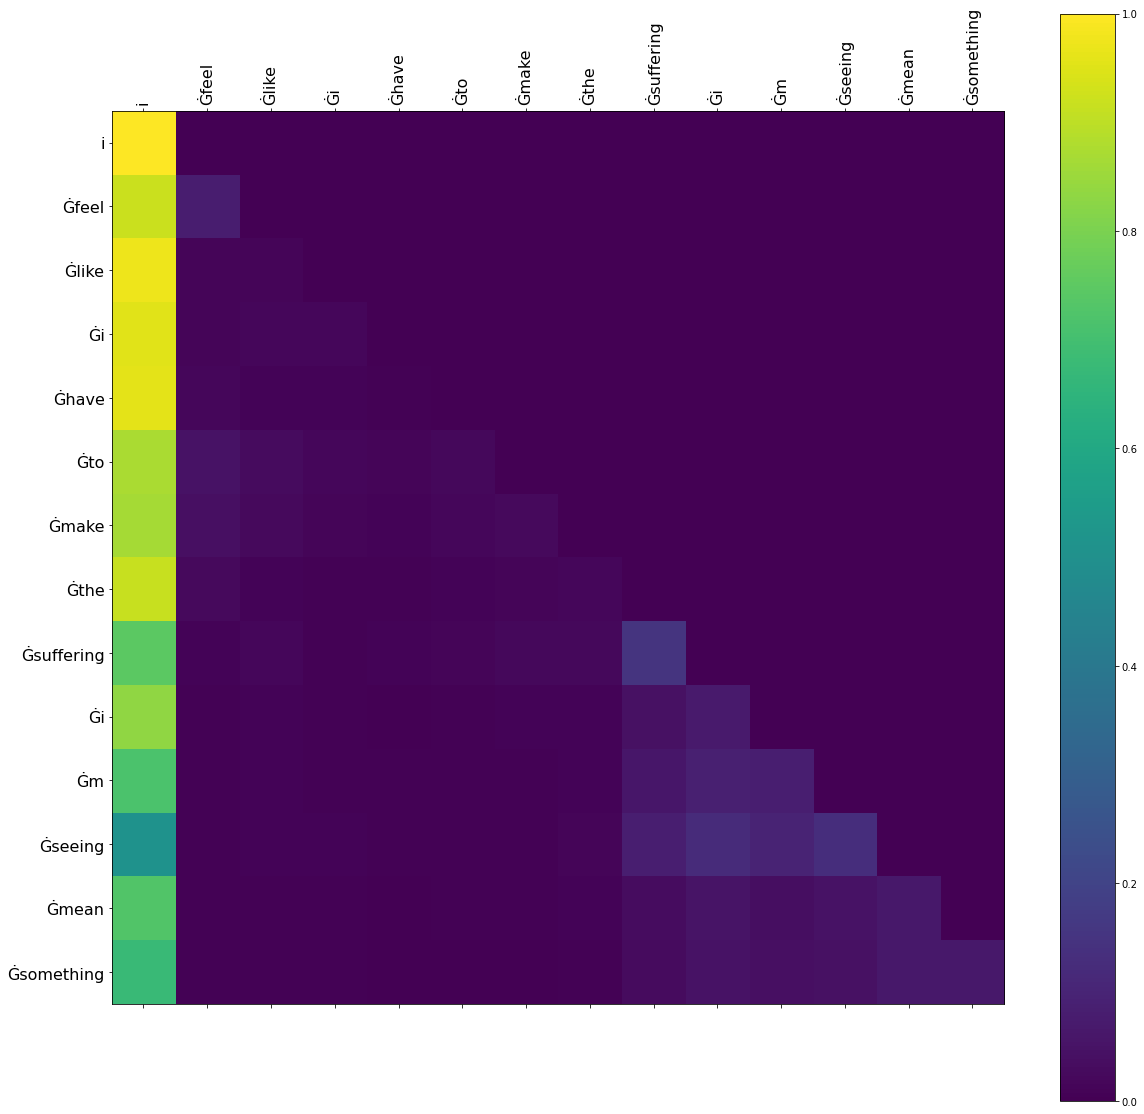

In [28]:
attns = get_attention_matrixes(model_1, tokenizer, text)
show_attention(tokens, attns[-1][0])

In [31]:
text = emotion_dataset['train']['text'][10]
inp = list(filter(lambda x: x != tokenizer.sep_token_id, tokenizer.encode(text)))
inp = torch.tensor(inp, dtype=torch.long, device=device).unsqueeze(0)
input_ids = tokenizer(text,return_tensors="pt",max_length=len(text))['input_ids']
attention = model_1(inp)[-1]
input_id_list = input_ids[0].tolist()
tokens = tokenizer.convert_ids_to_tokens(input_id_list)
call_html()
model_view(attention, tokens)

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


<IPython.core.display.Javascript object>

## Отчет

Покажи здесь, что ты выполнил по этой работе. Ответь на несколько вопросов:
- Какой подход оказался лучше? 
- На какие слова модель большего всего обращала внимание?
- На каких слоях/головах модель обращала внимание?


> Ответ: Fine-tuning модель оказалась лучше, но не на много, также, анализируя внимание обоих моделей, я обнаружил, что последняя модель больше ориентируется на состояние объектов, а не на чувства действующего лица, как первая, ещё одно отличие между моделями заключается в том, что у первой модели внимание более размазано (т.е сначала ориентируется на всё предложение, и только к концу выделяет отдельные слова), а вторая сразу пытается выделить некоторые слова и ориентируется только на них.

> Ответ: Модель обращала сильное внимание на первое слово (i), что не удивительно, ведь к нему (главному лицу) относится всё предложение; в некоторых предложениях модель находила дополнительные слова (прилагательные, наречия и т.д.), которые ей показались важными; в редких случаях модель обращала внимание на предыдущее слово или само слово. Также первая модель обращала сильное внимание на слова характеризующие ощущения (feel, like и т.д.).

> Ответ: Внимание к слову i характерно для всех слоёв и большинства голов; внимание к дополнительным словам более характерно для некоторых голов последних слоёв (т.к на первых модель ещё слабо ориентируется в предложении); внимание на пред.слово и само слово характерно для очень малого количества голов первых слоёв